In [2]:
!pip install monai -q --no-index --find-links=../input/vesuvis-downloads
!python -m pip install -q /kaggle/input/omegaconf222py3/omegaconf-2.2.2-py3-none-any.whl --no-index --find-links=/kaggle/input/omegaconf222py3/

## Importing Necessary Packages

In [3]:
import numpy as np 
import pandas as pd 
import os
import copy
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map
from tqdm.asyncio import tqdm as async_tqdm
from monai.inferers import SlidingWindowInferer
import pytorch_lightning as pl

import torch
import os
from typing import Union, Dict, Tuple
import cv2

2024-04-28 16:16:32.566905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 16:16:32.567026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 16:16:32.703598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Check if TPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Running on GPU')
else:
    device = torch.device("cpu")
    print('Running on CPU')

# Print the number of replicas
print("Number of replicas: ", torch.cuda.device_count() if torch.cuda.is_available() else 1)

Running on GPU
Number of replicas:  1


## **DataSet Preparation & Model Architecture Utils**

In [5]:
class BuildDataset:
    def __init__(self, dataset: str, is_test: bool = True):
        self.ids = []
        self.is_test = is_test

        self.xmin, self.xmax = 0, 0

        self.data_tensor = self.load_volume(dataset)
        self.shape_orig = self.data_tensor.shape
        
    def normilize(self, image: np.ndarray) -> np.ndarray:
        if image.dtype != np.half:
            image = image.astype(np.half, copy=False)
            
        image -= self.xmin
        image /= (self.xmax - self.xmin)
        
        np.clip(image, 0, 1, out=image)
        return image
    
    @staticmethod
    def norm_by_percentile(
        volume: np.ndarray, low: float = 10, high: float = 99.8
    ) -> Tuple:
        xmin = np.percentile(volume, low)
        xmax = np.max([np.percentile(volume, high), 1])
        return int(xmin), int(xmax)

    def load_volume(self, dataset: str) -> np.ndarray:
        path = os.path.join(dataset, "images", "*.tif")
        
        dataset = sorted(glob(path)) if self.is_test else sorted(glob(path))[:192]

        for p_img in tqdm(dataset):
            path_ = p_img.split(os.path.sep)
            slice_id, _ = os.path.splitext(path_[-1])
            self.ids.append(f"{path_[-3]}_{slice_id}")

        volume = None

        for z, path in enumerate(tqdm(dataset)):
            image = cv2.imread(path, cv2.IMREAD_ANYDEPTH).astype(np.half, copy=False)
            
            if volume is None:
                volume = np.zeros((len(dataset), *image.shape[-2:]), dtype=np.float16)
            volume[z, :, :] = image
            
        self.xmin, self.xmax = self.norm_by_percentile(volume)
        return volume

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Model architecture
class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(Conv2dBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool_type='avg', normalization=True):
        super(EncoderBlock, self).__init__()
        self.conv_block = Conv2dBlock(in_channels, out_channels)
        self.normalisation = normalization
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x_conv = self.conv_block(x)
        x = self.pool(x_conv)
        
        if self.normalisation:
            x = self.batch_norm(x)
            
        x = self.dropout(x)
        return x, x_conv

class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Bottleneck, self).__init__()
        self.conv_block = Conv2dBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.conv_block(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, normalization=True):
        super(DecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, output_padding=1)
        self.conv_block = Conv2dBlock(in_channels, out_channels, kernel_size)
        self.normalisation = normalization
        
        self.batch_norm = nn.BatchNorm2d(in_channels)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x, skip_connection):
        
        # Apply padding
        x = self.conv_transpose(x)
        x = torch.cat([x, skip_connection], dim=1)
        if self.normalisation:
            x = self.batch_norm(x)
            
        x = self.dropout(x)
        x = self.conv_block(x)
        return x
    

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256, normalization=False)
        self.encoder4 = EncoderBlock(256, 512, normalization=False)
        self.bottleneck = Bottleneck(512, 1024)
        self.decoder1 = DecoderBlock(1024, 512, normalization=False)
        self.decoder2 = DecoderBlock(512, 256, normalization=False)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder4 = DecoderBlock(128, 64)
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1, conv1 = self.encoder1(x)
        enc2, conv2 = self.encoder2(enc1)
        enc3, conv3 = self.encoder3(enc2)
        enc4, conv4 = self.encoder4(enc3)
        bottleneck = self.bottleneck(enc4)
        dec1 = self.decoder1(bottleneck, conv4)
        dec2 = self.decoder2(dec1, conv3)
        dec3 = self.decoder3(dec2, conv2)
        dec4 = self.decoder4(dec3, conv1)
        output = self.output(dec4)
#         output = nn.functional.sigmoid(output)
        return output



def rle_encode(mask):
    """
    rle encoder (thanks to the community)
    """
    pixel = mask.flatten()
    pixel[pixel<0.9] = 0
    pixel[pixel>=0.9] = 1 
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 1'
    return rle

## **Loading Validation data (kidney 3) and Model saved weights**

In [7]:
import tifffile

def rename_keys(state_dict, prefix):
    return {k[len(prefix):]: v for k, v in state_dict.items() if k.startswith(prefix)}

MAIN_PATH = '/kaggle/input/blood-vessel-segmentation'
dense_folder = '/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense/labels'
base_folder = '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/labels'
VALIDATION = MAIN_PATH + '/train/kidney_3_sparse'

# To use model trained under concrete loss upload an appropriate weights
WEIGHTS_PATH = '/kaggle/input/unet-bdou-loss-weights/UNet_BoundaryDoULoss_size_1_512_bs32_hard/0/checkpoints/last.ckpt'
updated_state_dict = rename_keys(torch.load(WEIGHTS_PATH, map_location="cpu")["state_dict"], "net.")

model = UNet(1, 1)
model.load_state_dict(updated_state_dict)
model.to(device)

# List all files in the folders and sort them
base_masks = sorted([os.path.join(base_folder, f) for f in os.listdir(base_folder) if f.endswith('.tif')])
dense_masks = sorted([os.path.join(dense_folder, f) for f in os.listdir(dense_folder) if f.endswith('.tif')])

# Dictionary to store masks
all_masks = {}

# Load masks from base folder
for mask_path in tqdm(base_masks):
    mask_name = os.path.basename(mask_path)[:-4]
    all_masks[f'kidney_3_sparse_{mask_name}'] = tifffile.imread(mask_path)

# Load masks from dense folder, overwrite if exists
for mask_path in tqdm(dense_masks):
    mask_name = os.path.basename(mask_path)[:-4]
    all_masks[f'kidney_3_sparse_{mask_name}'] = tifffile.imread(mask_path)

100%|██████████| 501/501 [00:08<00:00, 56.20it/s]


In [8]:
from torchmetrics.classification import Dice

ground_truth_masks = list(all_masks.values())
rles_pred, rles_ground_truth, ids, pred_masks = [], [], [], []
inferer = SlidingWindowInferer(mode='gaussian', roi_size=(512,512))
metric_dice = Dice()

test_dataset = BuildDataset(VALIDATION, is_test=True)

# Apply to images stackwise normalization
input_tensor = torch.from_numpy(test_dataset.normilize(test_dataset.data_tensor)).unsqueeze(1)

100%|██████████| 1035/1035 [01:37<00:00, 10.60it/s]


## **Comparing Ground Thruth mask vs Predicted incorporating different Losses and Threshold of 0.5**

In [10]:
test_img = input_tensor[555]
selected_mask = tifffile.imread('/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense/labels/0555.tif')
file_path = '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images/0555.tif'
img_array = plt.imread(file_path)
pred_masks = []
# To overview model performance trained under concrete loss upload an appropriate weights
model.eval()
with torch.no_grad():
    ids += test_dataset.ids
    tensor = test_img.float().unsqueeze(0).to(device)

    output = inferer(inputs=tensor, network=model)
    pred_masks.append(output.cpu().squeeze())
    
sel = selected_mask/255
pred = pred_masks[0]
pred[pred < 0.5] = 0
pred[pred >= 0.5] = 1

### **BCEDice Loss**

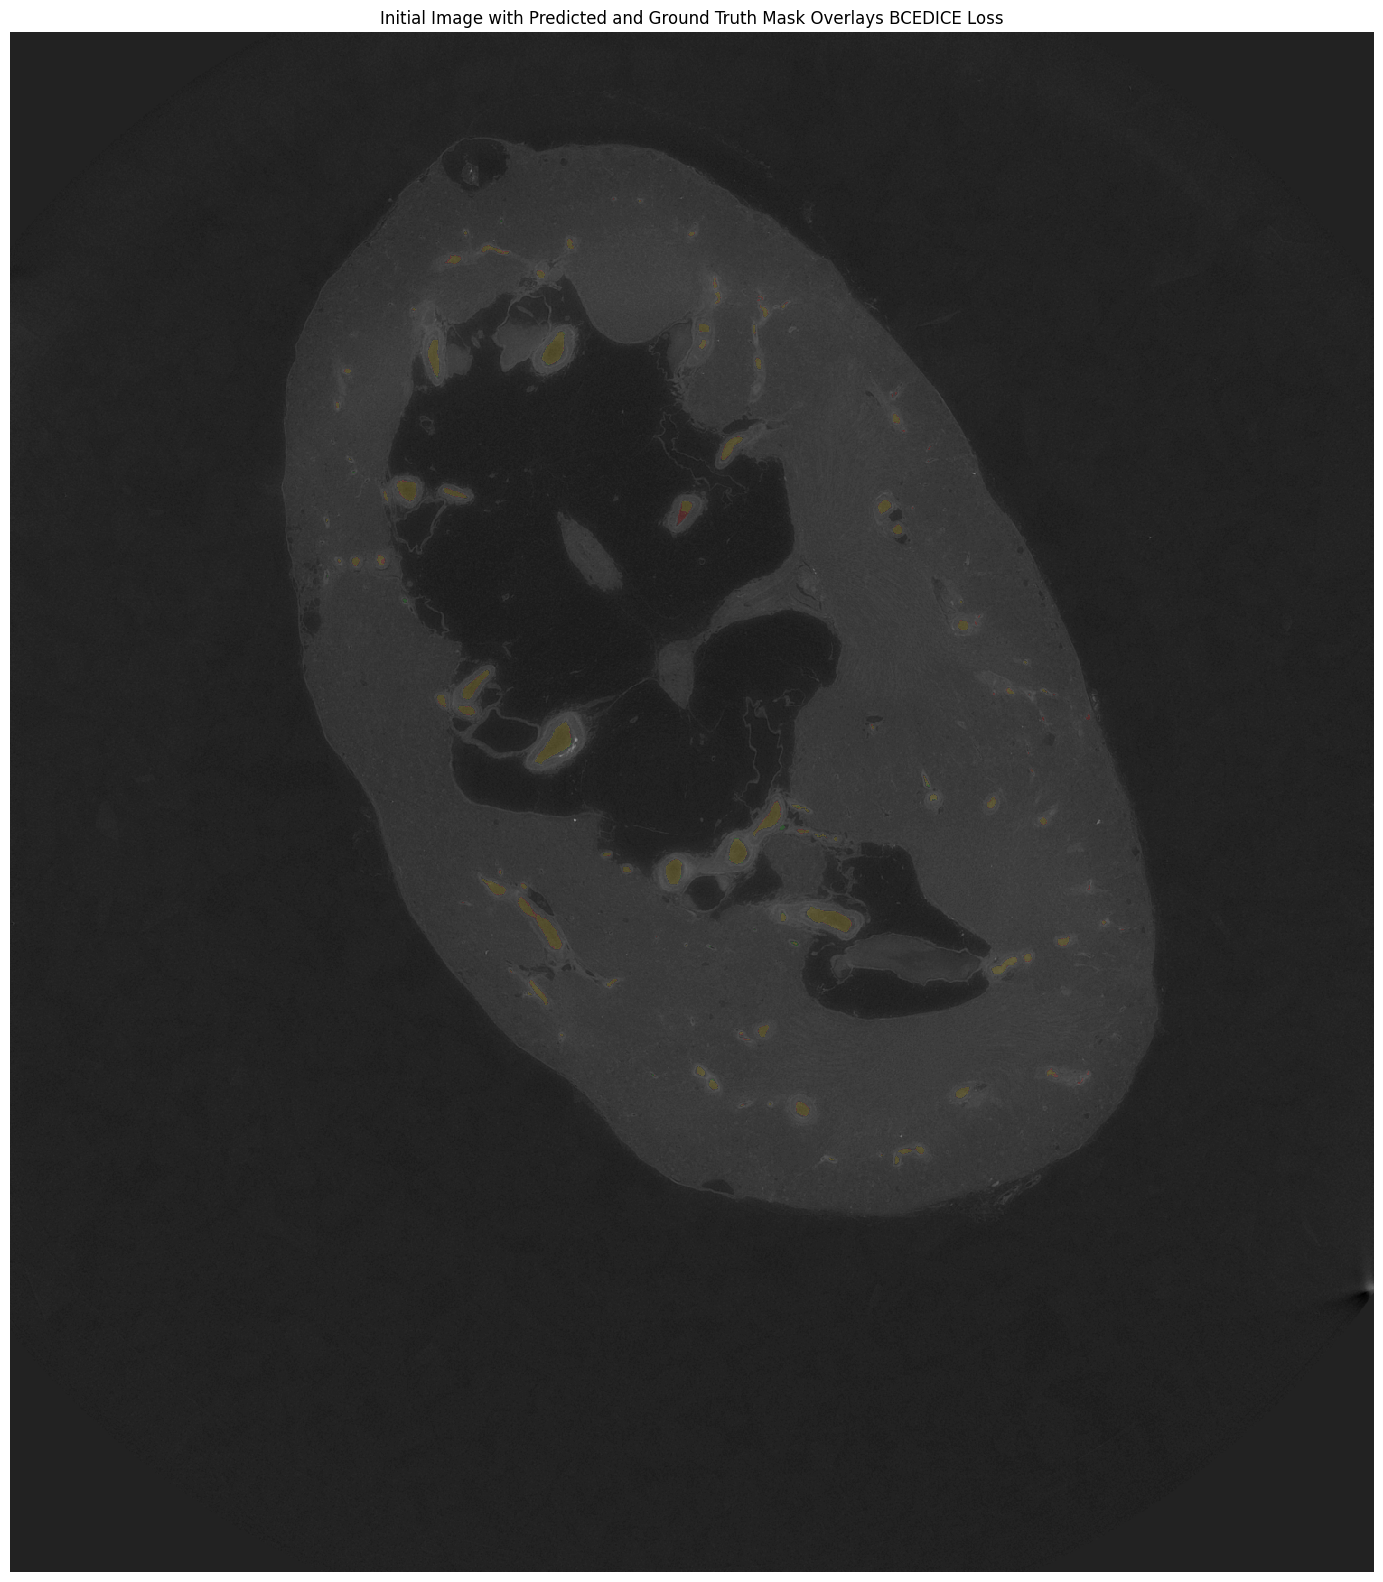

In [16]:
# Create a plot
plt.figure(figsize=(20, 20))

# Show initial image in grayscale
plt.imshow(img_array, cmap='gist_gray', interpolation='none')

# Overlay predicted mask where it is 1 (make these pixels red)
predicted_color_mask = np.zeros((*pred.shape, 3))  
predicted_color_mask[pred == 1] = [0, 1, 0] 
plt.imshow(predicted_color_mask, interpolation='none', alpha=0.15)

ground_truth_color_mask = np.zeros((*sel.shape, 3)) 
ground_truth_color_mask[sel == 1] = [1, 0, 0] 
plt.imshow(ground_truth_color_mask, interpolation='none', alpha=0.15)


plt.title('Initial Image with Predicted and Ground Truth Mask Overlays BCEDICE Loss')
plt.grid(False)
plt.axis('off') 
plt.show()


### **BCE Loss**

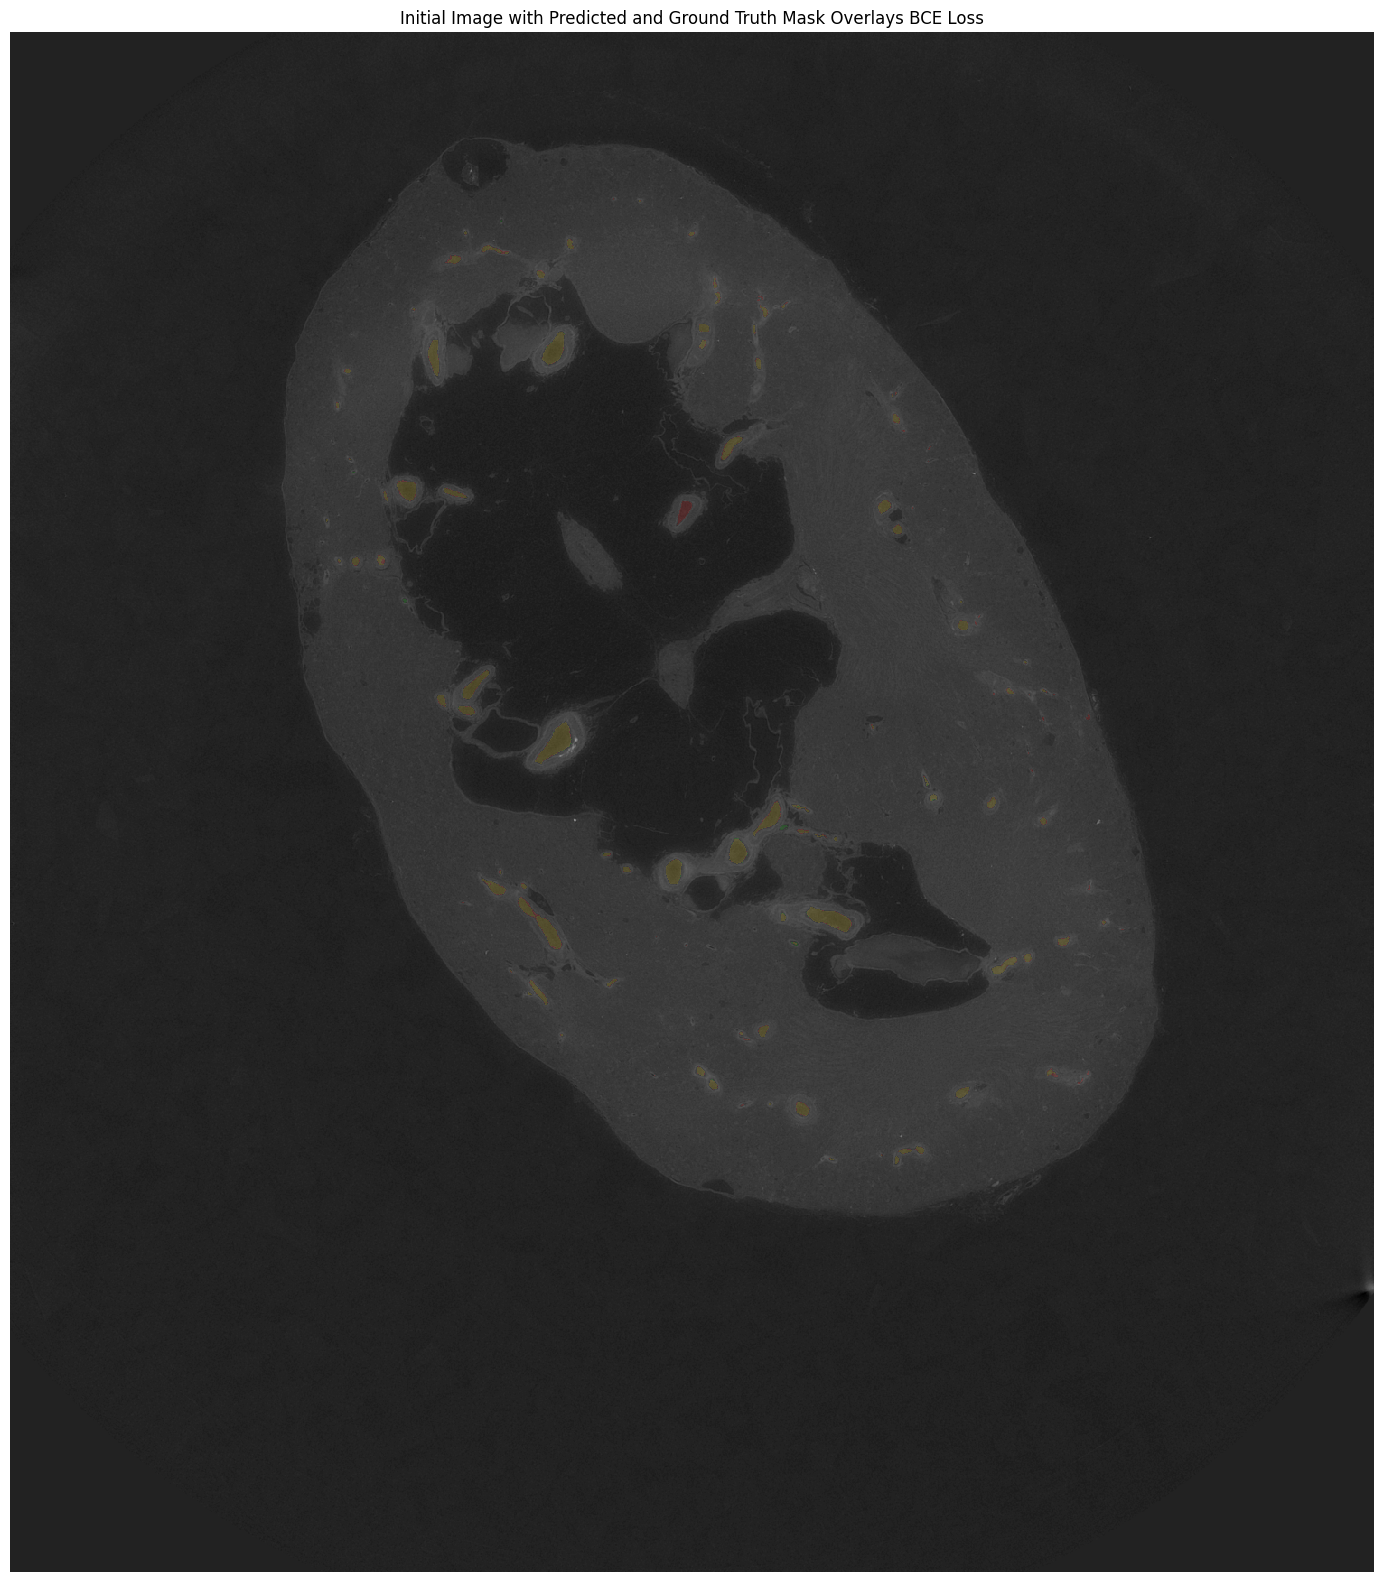

In [11]:
# Create a plot
plt.figure(figsize=(20, 20))

# Show initial image in grayscale
plt.imshow(img_array, cmap='gist_gray', interpolation='none')

# Overlay predicted mask where it is 1 (make these pixels red)
predicted_color_mask = np.zeros((*pred.shape, 3))  
predicted_color_mask[pred == 1] = [0, 1, 0] 
plt.imshow(predicted_color_mask, interpolation='none', alpha=0.15)

ground_truth_color_mask = np.zeros((*sel.shape, 3)) 
ground_truth_color_mask[sel == 1] = [1, 0, 0] 
plt.imshow(ground_truth_color_mask, interpolation='none', alpha=0.15)

plt.title('Initial Image with Predicted and Ground Truth Mask Overlays BCE Loss')
plt.grid(False)
plt.axis('off') 
plt.show()


### **BDoU Loss**

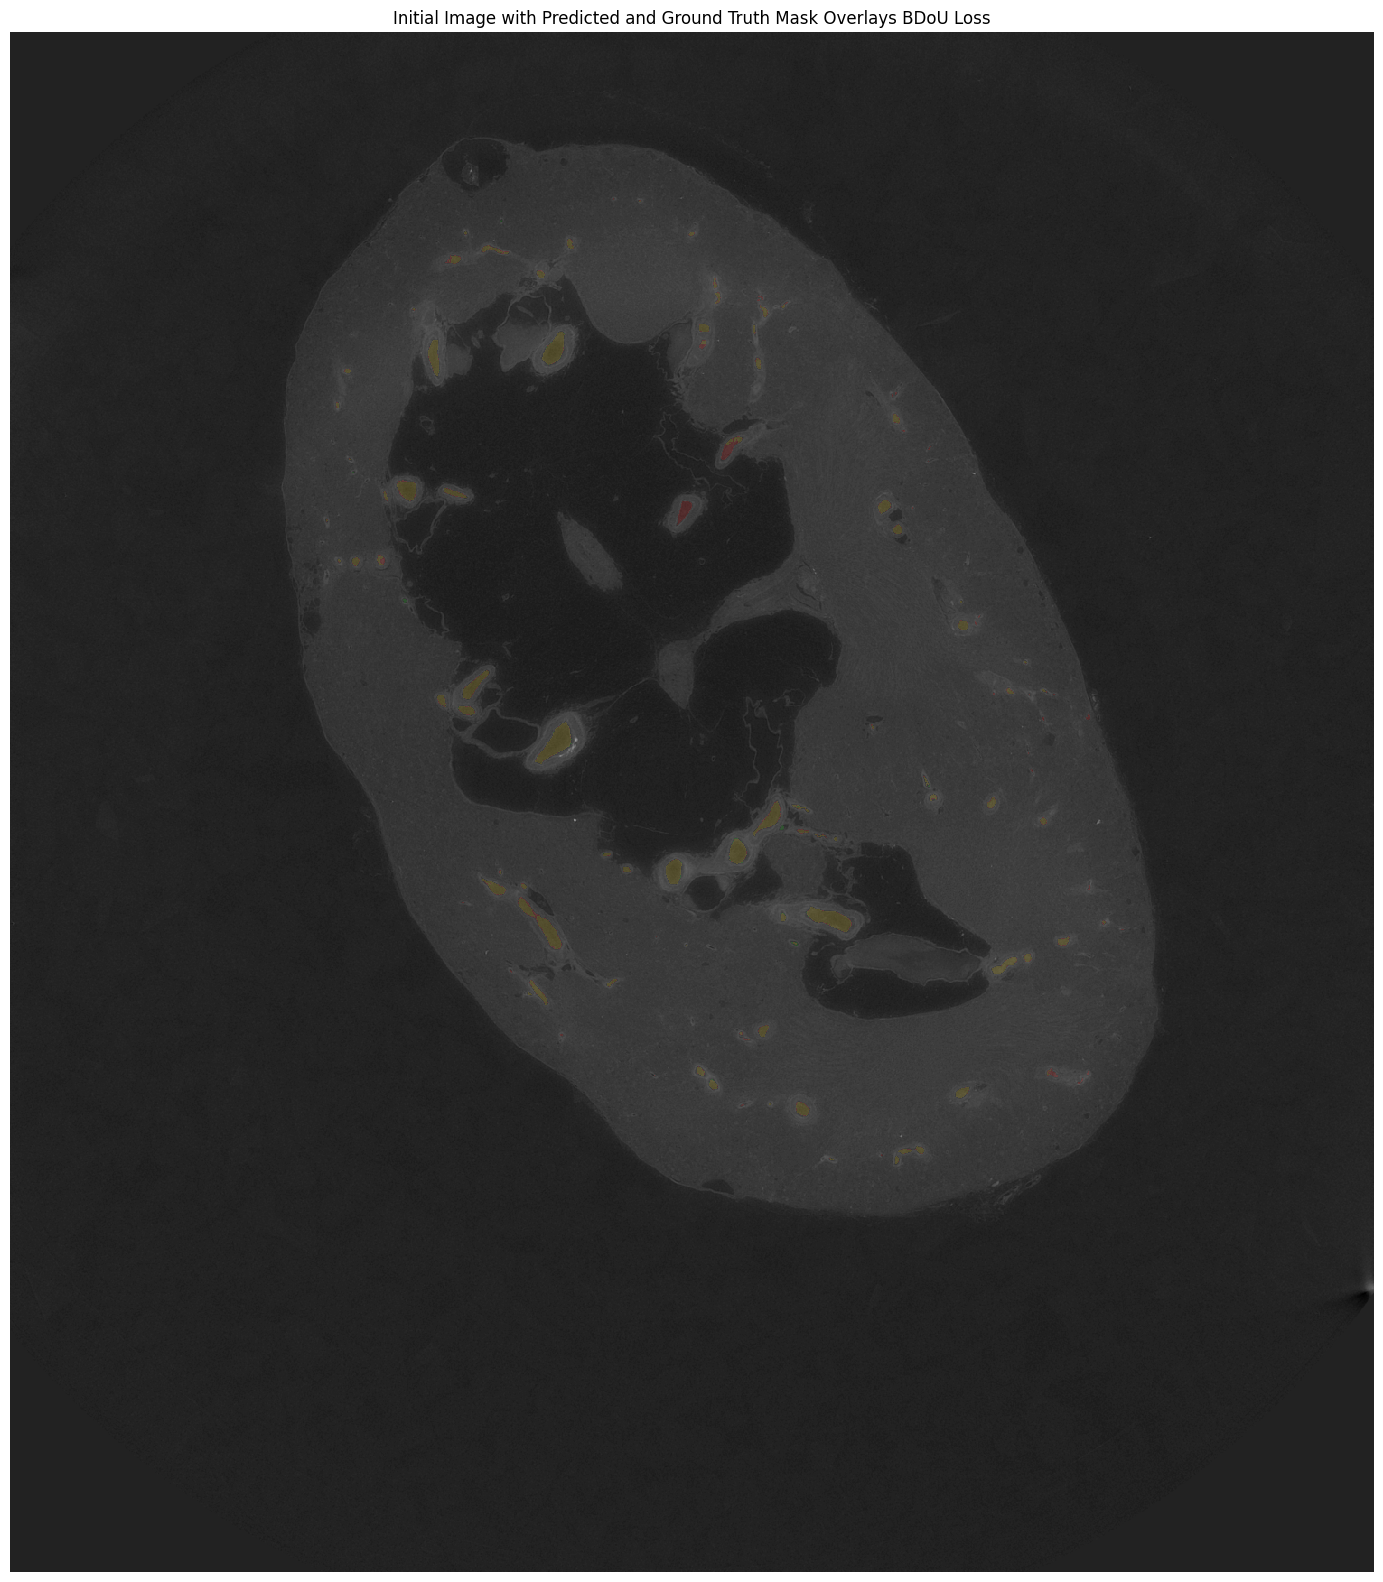

In [10]:
# Create a plot
plt.figure(figsize=(20, 20))

# Show initial image in grayscale
plt.imshow(img_array, cmap='gist_gray', interpolation='none')

# Overlay predicted mask where it is 1 (make these pixels red)
predicted_color_mask = np.zeros((*pred.shape, 3))  
predicted_color_mask[pred == 1] = [0, 1, 0] 
plt.imshow(predicted_color_mask, interpolation='none', alpha=0.15)

ground_truth_color_mask = np.zeros((*sel.shape, 3)) 
ground_truth_color_mask[sel == 1] = [1, 0, 0] 
plt.imshow(ground_truth_color_mask, interpolation='none', alpha=0.15)

plt.title('Initial Image with Predicted and Ground Truth Mask Overlays BDoU Loss')
plt.grid(False)
plt.axis('off') 
plt.show()


### **Focal Loss**

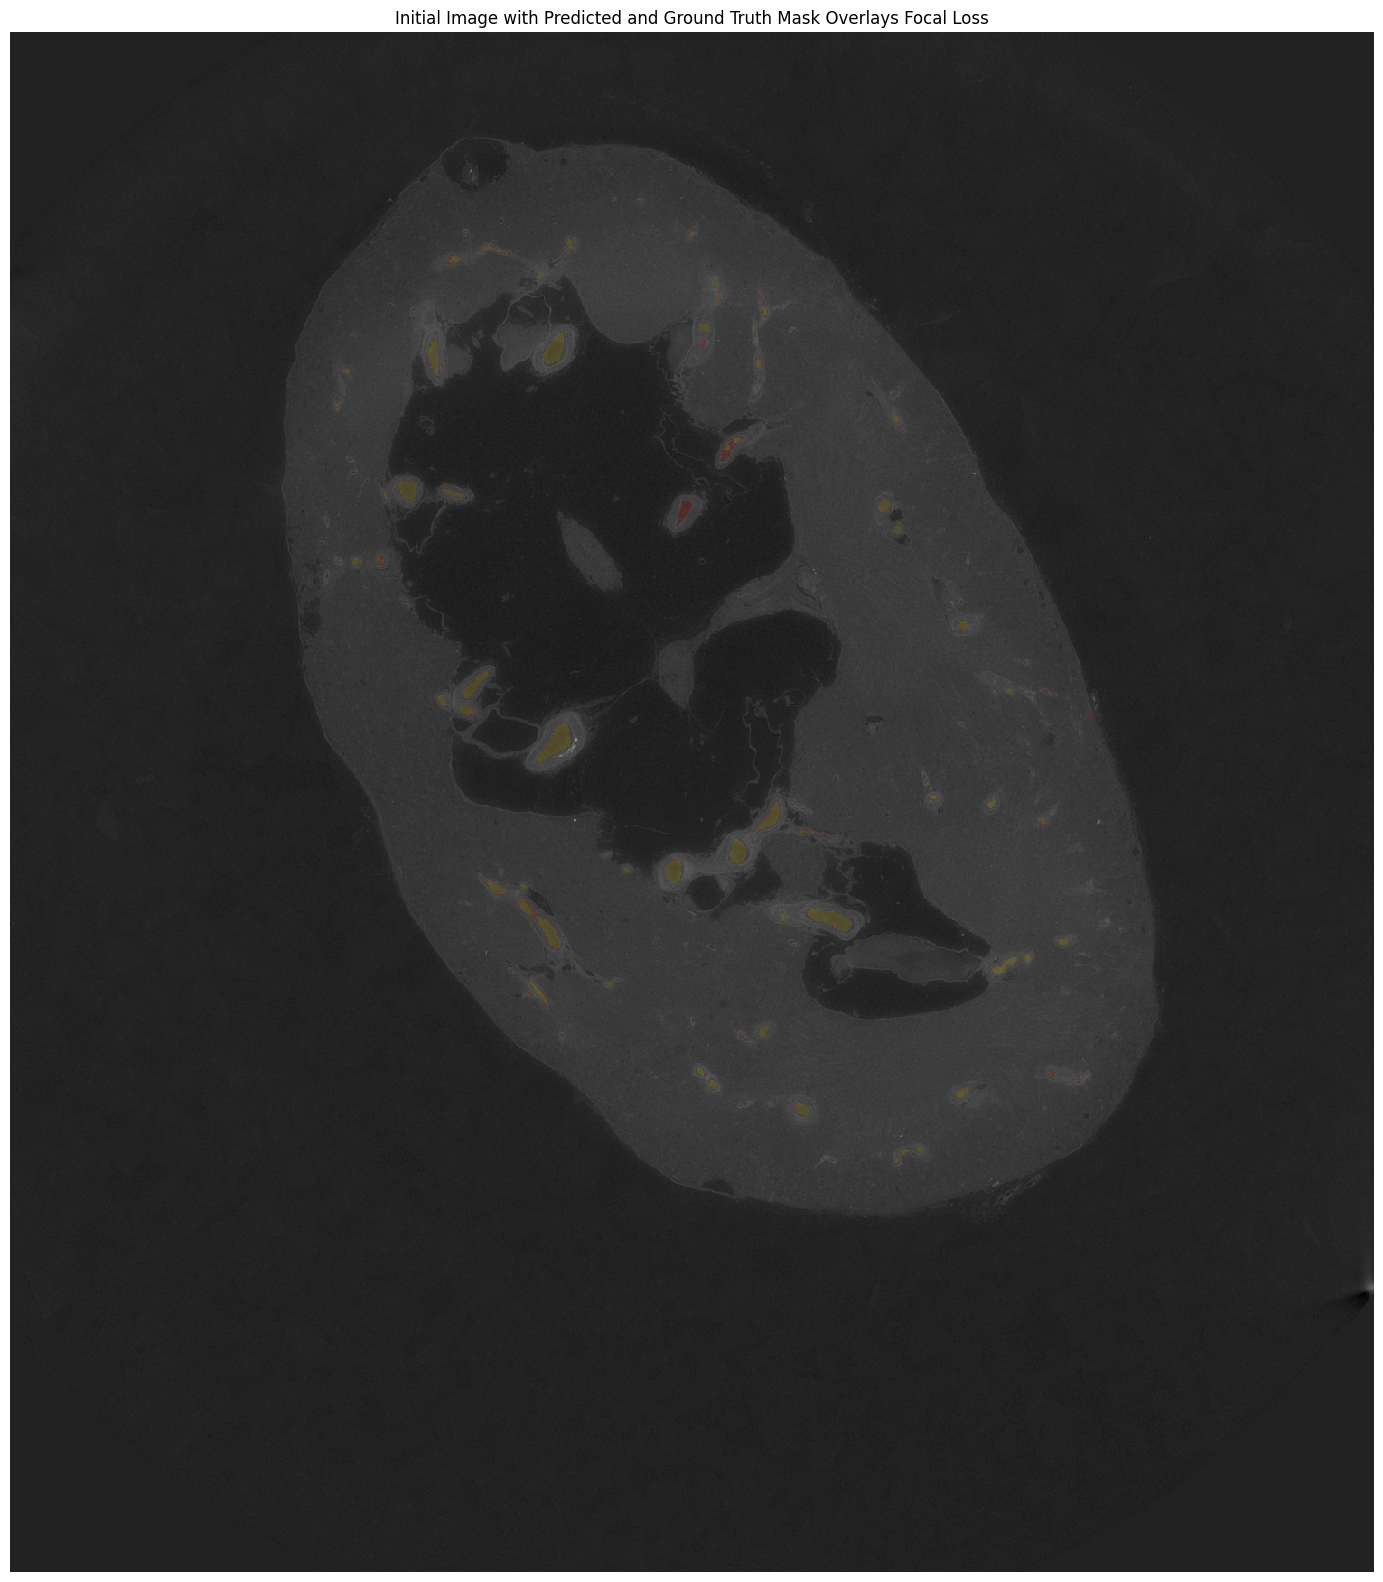

In [72]:
# Create a plot
plt.figure(figsize=(20, 20))

# Show initial image in grayscale
plt.imshow(img_array, cmap='gist_gray', interpolation='none')

# Overlay predicted mask where it is 1 (make these pixels red)
predicted_color_mask = np.zeros((*pred.shape, 3))  
predicted_color_mask[pred == 1] = [0, 1, 0] 
plt.imshow(predicted_color_mask, interpolation='none', alpha=0.15)

ground_truth_color_mask = np.zeros((*sel.shape, 3)) 
ground_truth_color_mask[sel == 1] = [1, 0, 0] 
plt.imshow(ground_truth_color_mask, interpolation='none', alpha=0.15)

plt.title('Initial Image with Predicted and Ground Truth Mask Overlays Focal Loss')
plt.grid(False)
plt.axis('off') 
plt.show()


### **BDoUV2 Loss**

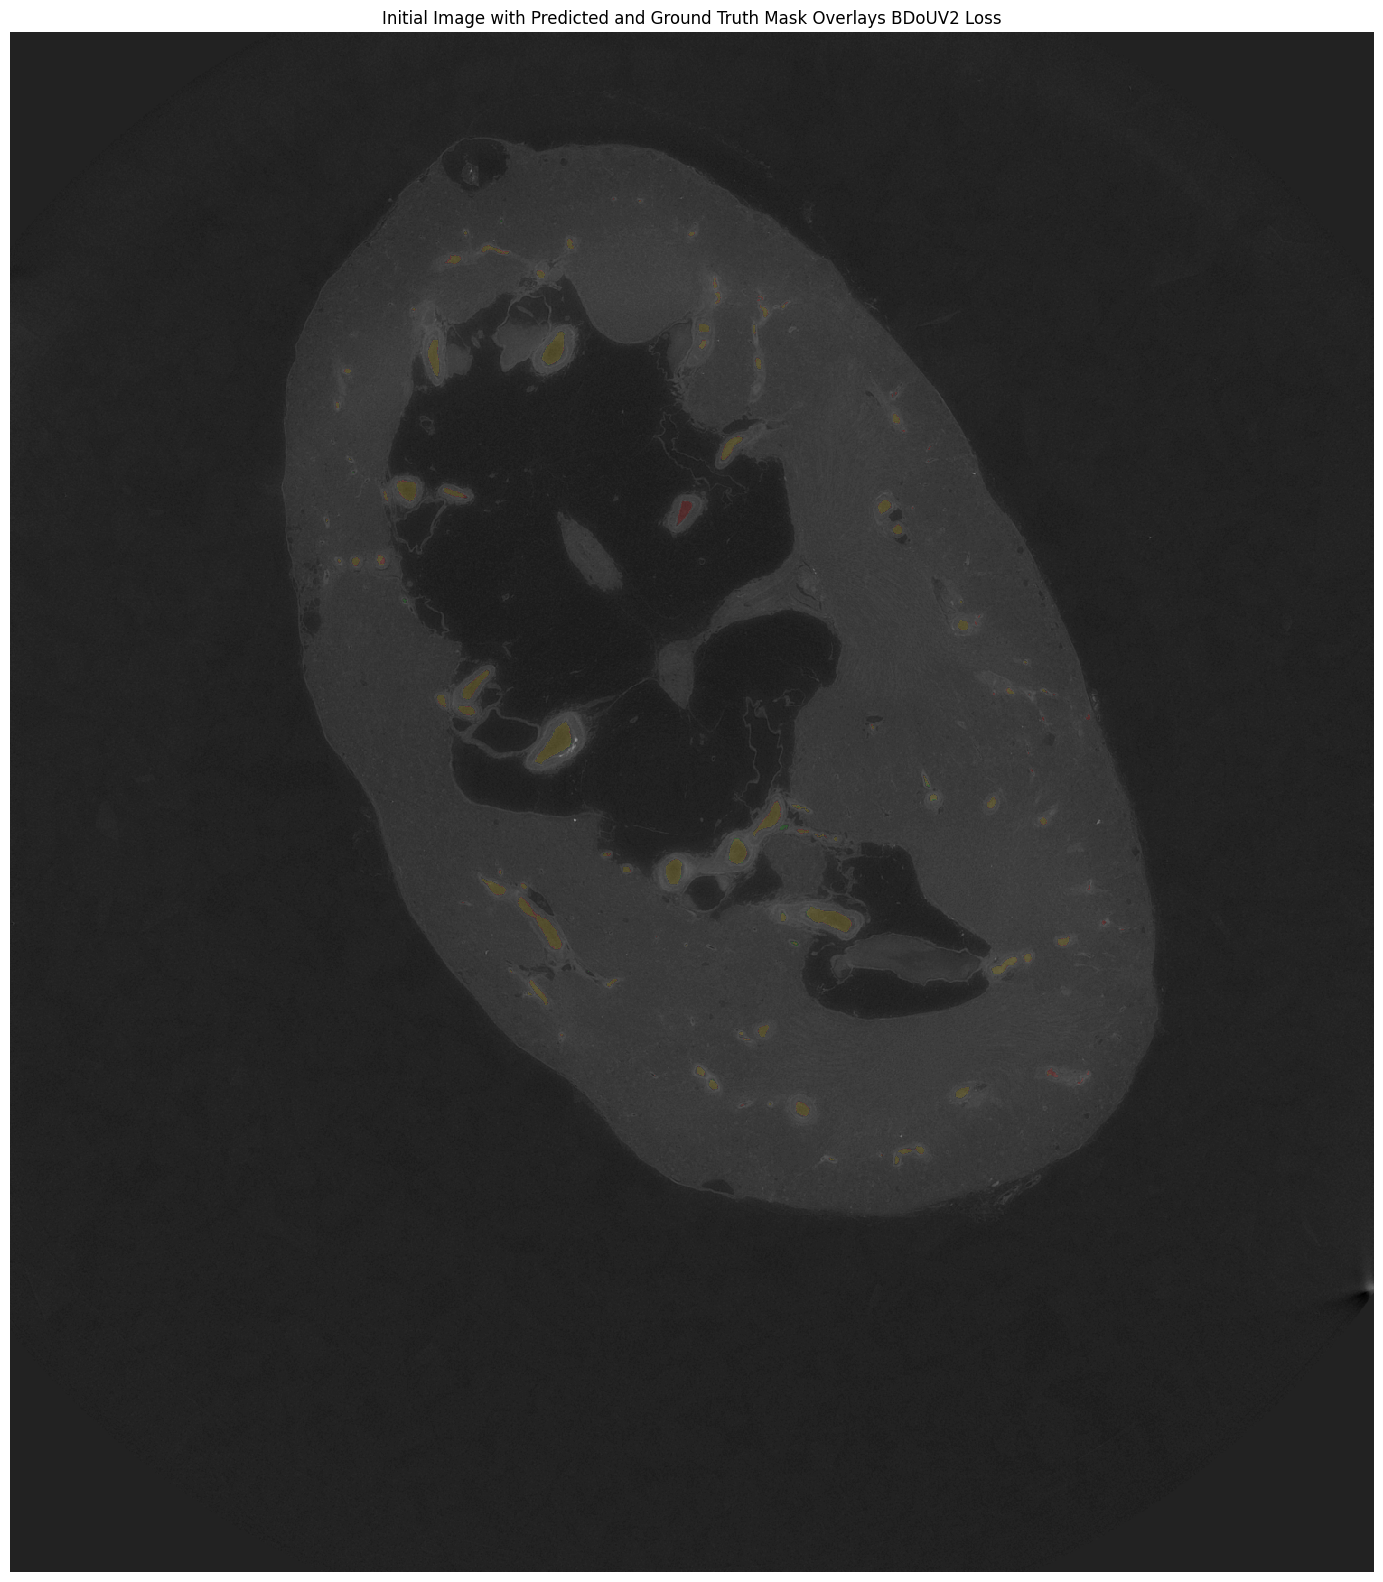

In [11]:
# Create a plot
plt.figure(figsize=(20, 20))

# Show initial image in grayscale
plt.imshow(img_array, cmap='gist_gray', interpolation='none')

# Overlay predicted mask where it is 1 (make these pixels red)
predicted_color_mask = np.zeros((*pred.shape, 3))  
predicted_color_mask[pred == 1] = [0, 1, 0] 
plt.imshow(predicted_color_mask, interpolation='none', alpha=0.15)

ground_truth_color_mask = np.zeros((*sel.shape, 3)) 
ground_truth_color_mask[sel == 1] = [1, 0, 0] 
plt.imshow(ground_truth_color_mask, interpolation='none', alpha=0.15)

plt.title('Initial Image with Predicted and Ground Truth Mask Overlays BDoUV2 Loss')
plt.grid(False)
plt.axis('off')
plt.show()


## **Plotting Confusion matrices under different Threshold values**

In [15]:
import copy
import seaborn as sns
from sklearn.metrics import confusion_matrix

random_indices = [509, 774, 749, 552, 459, 627, 418, 825, 478, 477]
selected_img = input_tensor[random_indices]
selected_mask = np.array(ground_truth_masks)[random_indices]
thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
pred_masks = []

# To plot confusion matrices under different losses, upload appropriate model weights
model.eval()
with torch.no_grad():
    ids += test_dataset.ids
    for idx, tensor in tqdm(enumerate(selected_img)):
        tensor = tensor.float().unsqueeze(0).to(device)
            
        output = inferer(inputs=tensor, network=model)
        pred_masks.append(output.cpu().squeeze())

        
def plot_confusion_matrix(pred_masks, selected_mask, thresholds, loss):
    preds = np.array(copy.deepcopy(pred_masks))
    # Loop over each threshold
    for threshold in thresholds:
        # Binarize predicted masks based on the threshold
        binarized_pred_masks = (preds >= threshold).astype(int)
        
        # Flatten arrays
        flattened_gt_masks = selected_mask.flatten() / 255
        flattened_binarized_pred_masks = binarized_pred_masks.flatten()
        
        # Calculate confusion matrix
        cm = confusion_matrix(flattened_gt_masks, flattened_binarized_pred_masks)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.2)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True, 
                    xticklabels=['Class 0', 'Class 1'], 
                    yticklabels=['Class 0', 'Class 1'])
        plt.title(f'Confusion Matrix {loss} Loss (Threshold = {threshold})')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


10it [00:08,  1.25it/s]


### **BCEDice Loss**

--BCEDice Loss--


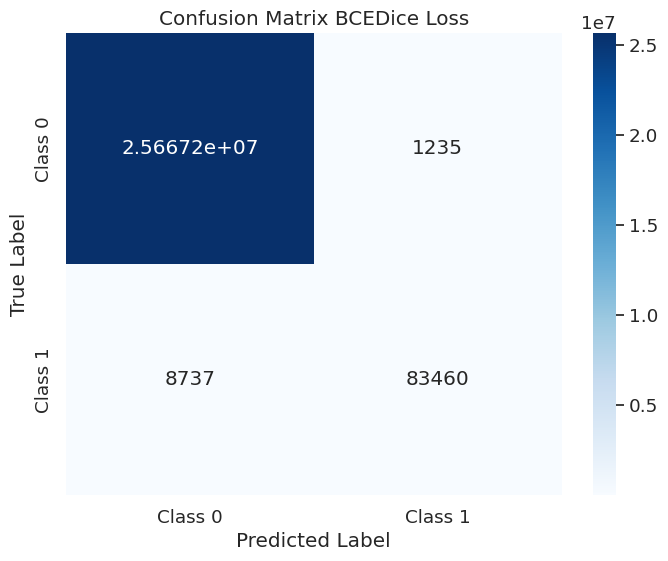

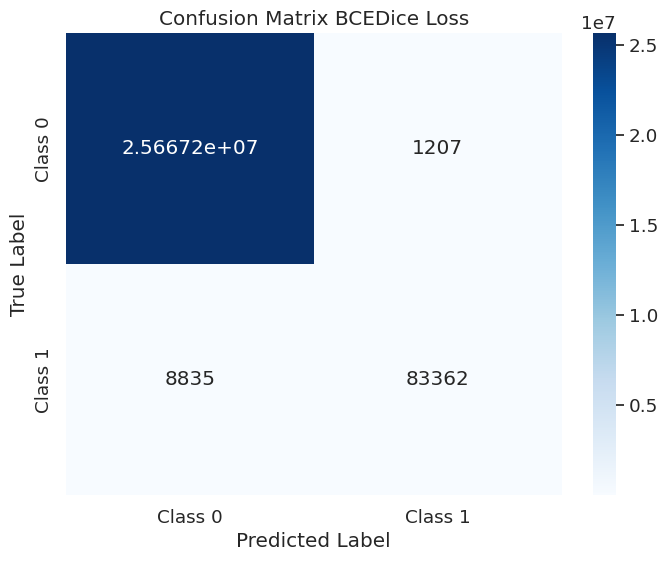

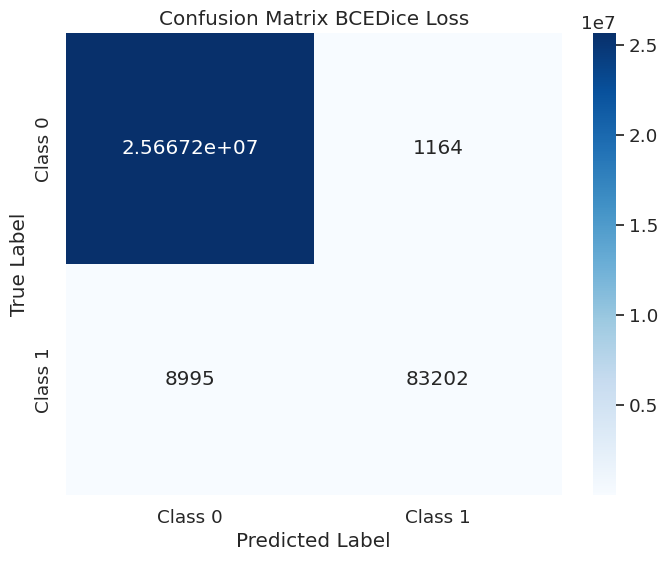

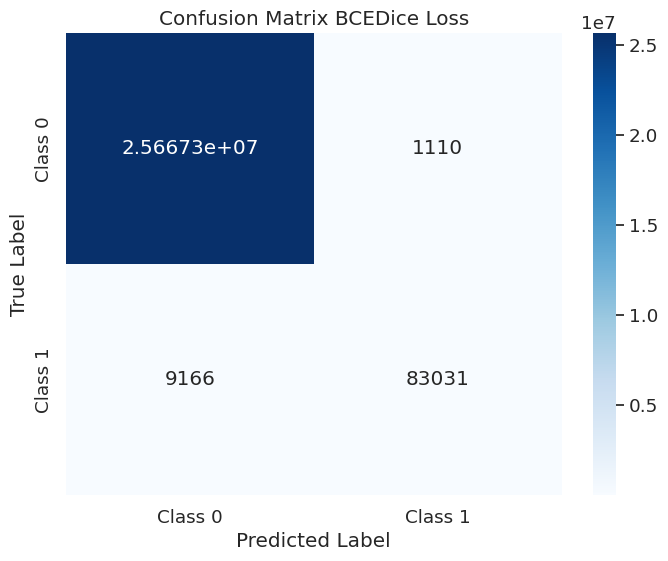

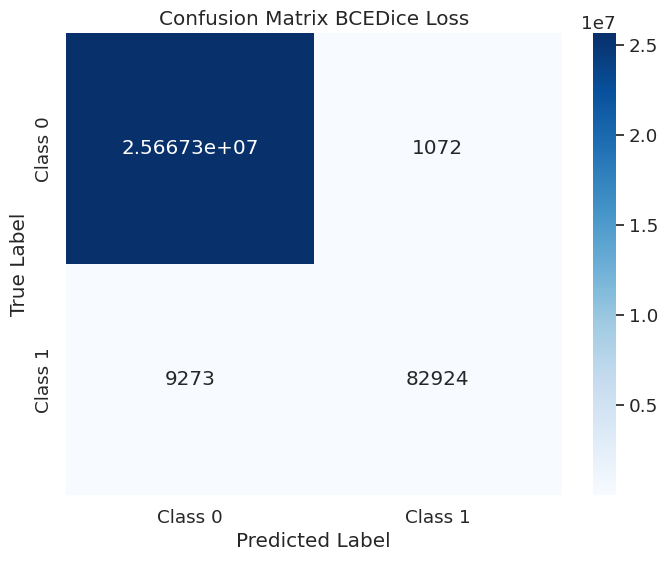

In [25]:
print('--BCEDice Loss--')
plot_confusion_matrix(pred_masks, selected_mask, thresholds, 'BCEDice')

### **BCE Loss**

--BCE Loss--


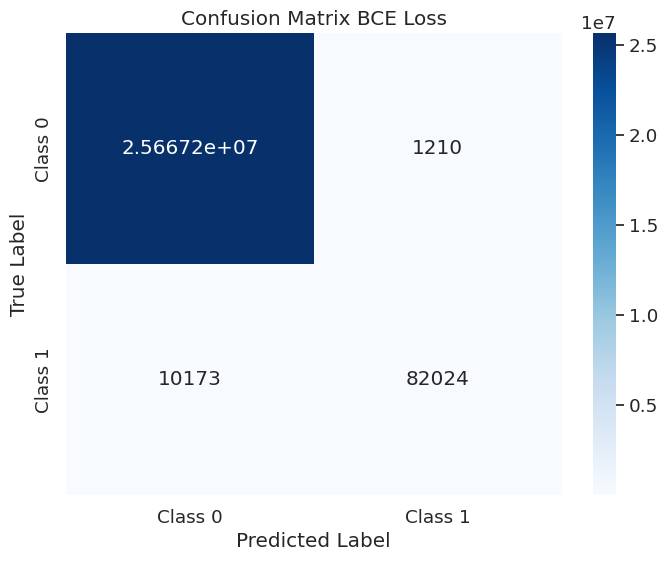

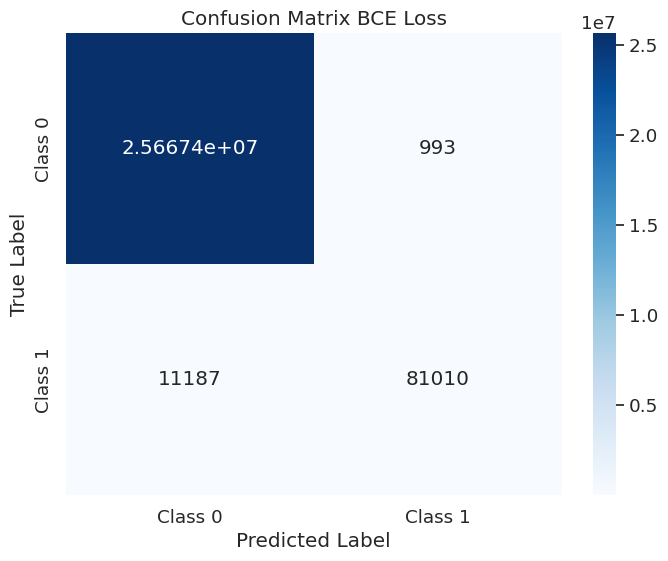

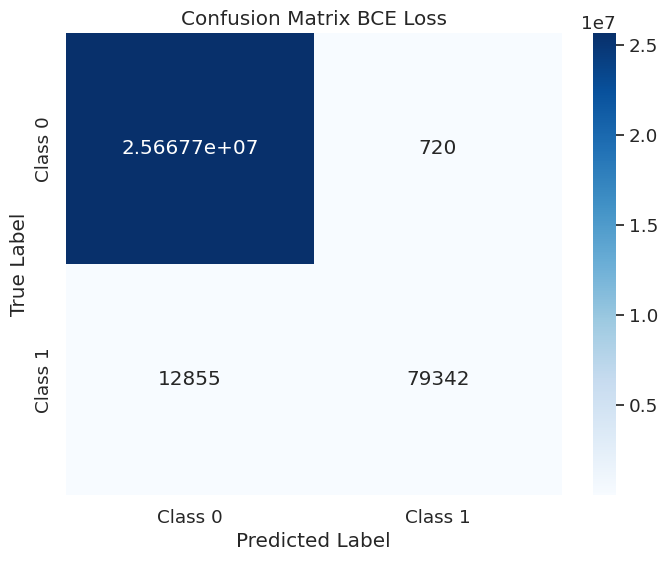

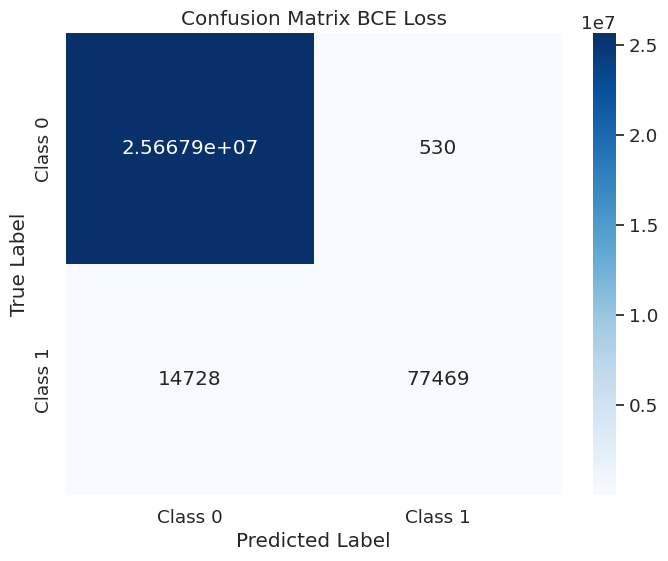

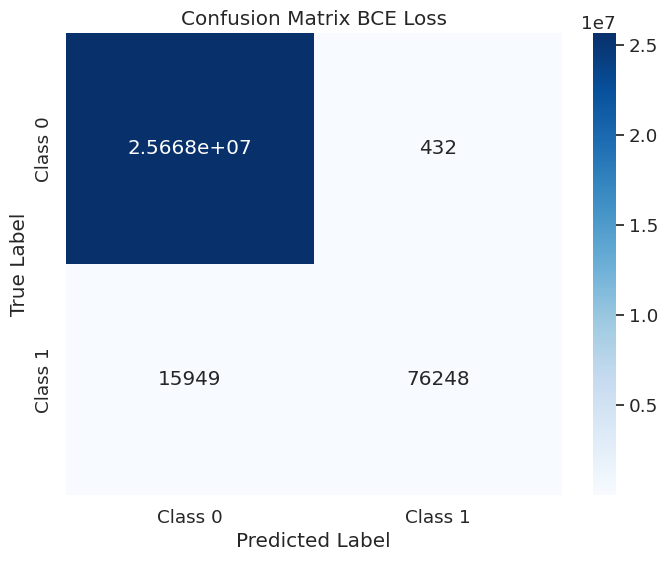

In [21]:
print('--BCE Loss--')
plot_confusion_matrix(pred_masks, selected_mask, thresholds, 'BCE')

### **BDoU Loss**

--BDoU Loss--


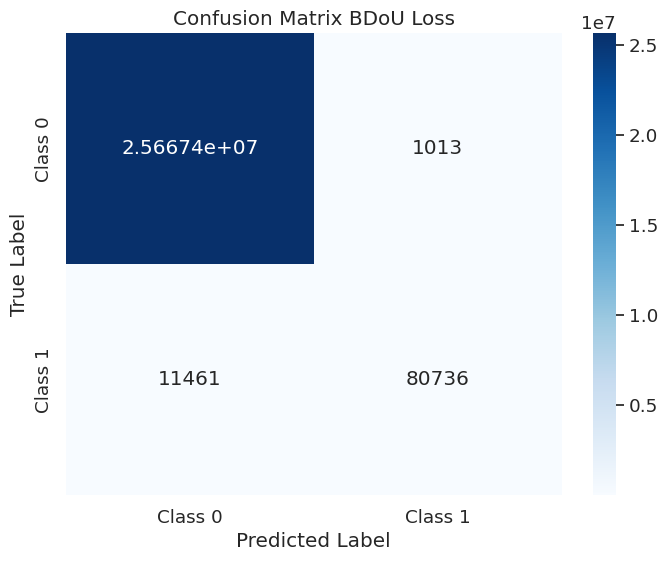

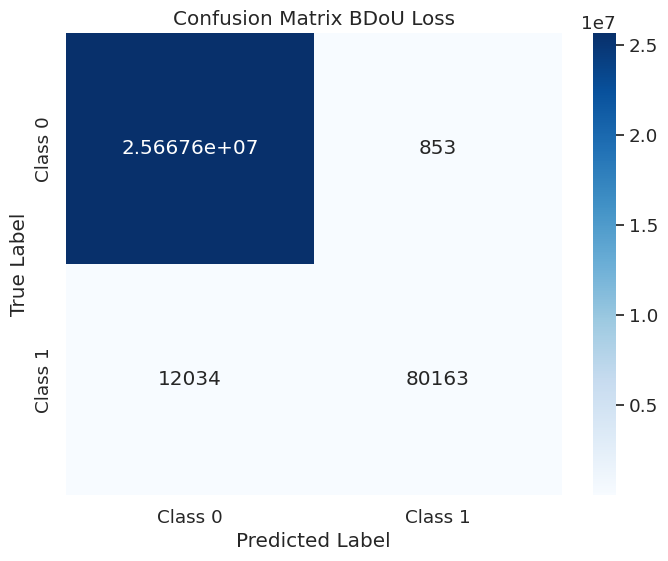

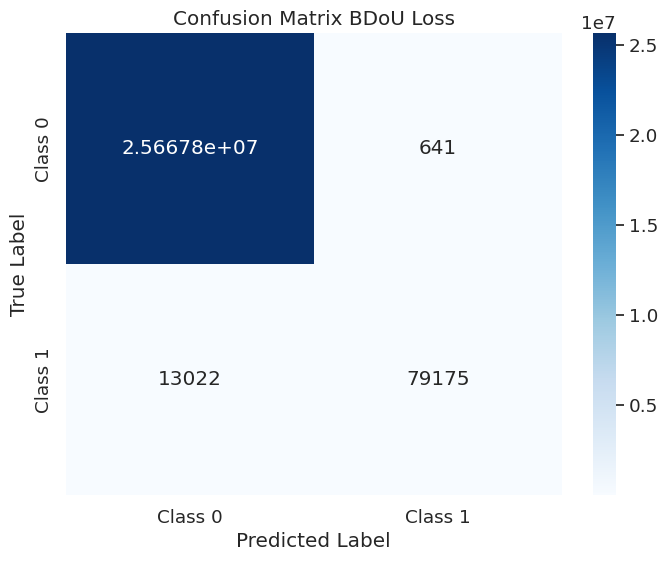

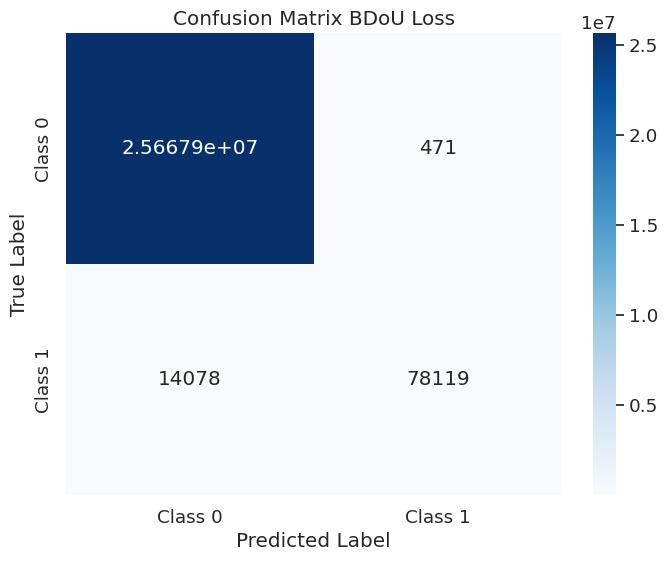

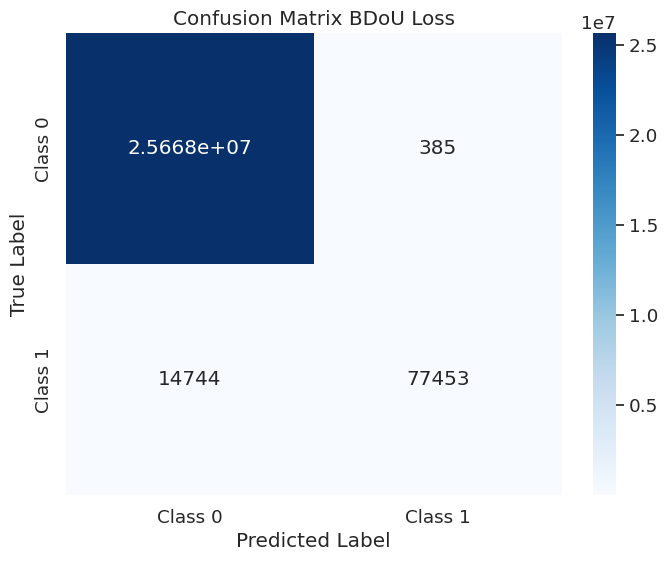

In [9]:
print('--BDoU Loss--')
plot_confusion_matrix(pred_masks, selected_mask, thresholds, 'BDoU')

### **BDoUV2 Loss**

--BDoUV2 Loss--


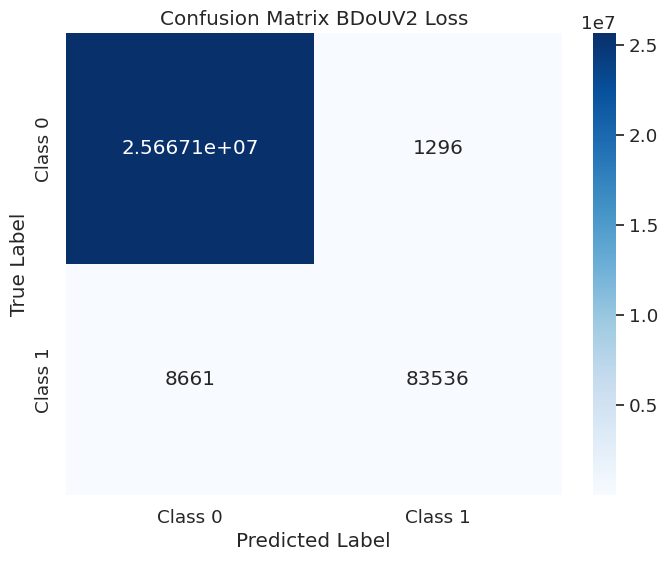

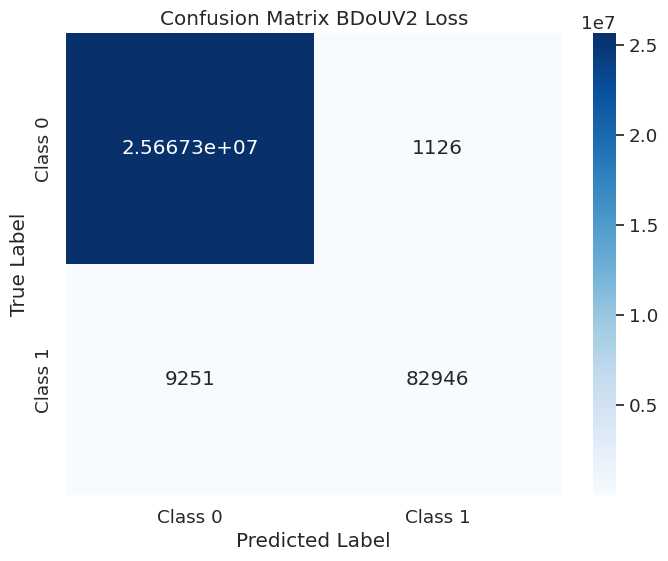

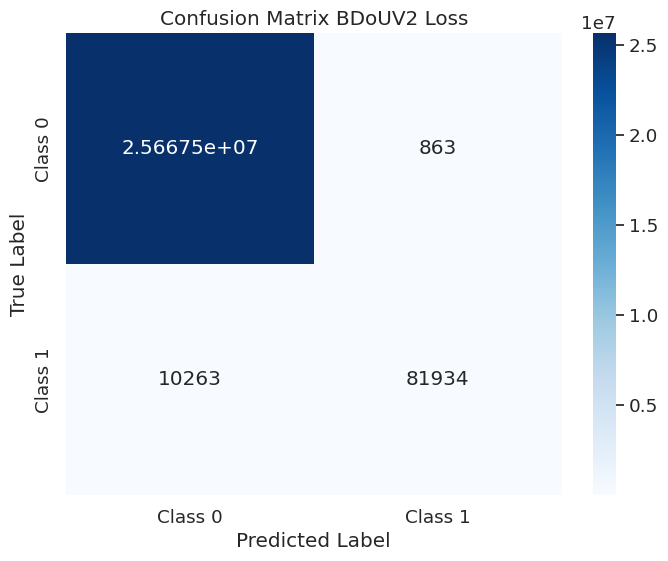

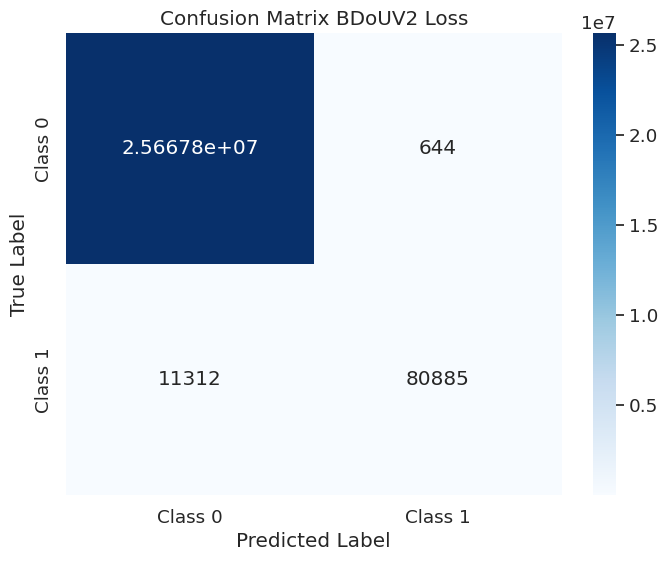

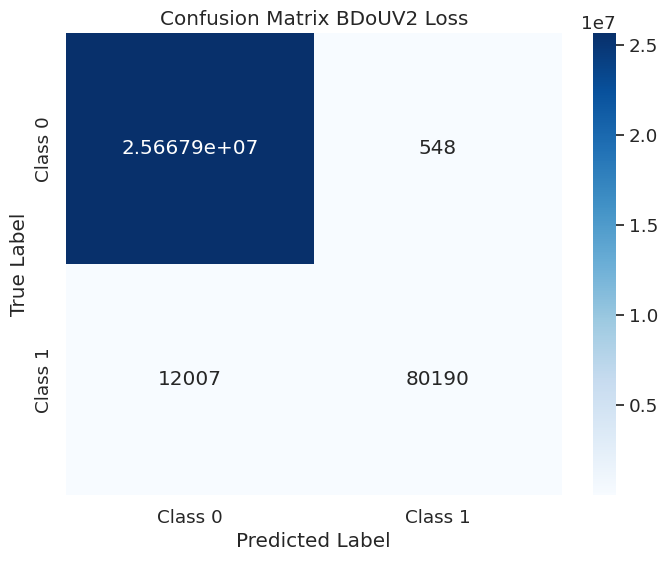

In [13]:
print('--BDoUV2 Loss--')
plot_confusion_matrix(pred_masks, selected_mask, thresholds, 'BDoUV2')

### **Focal Loss**

--Focal Loss--


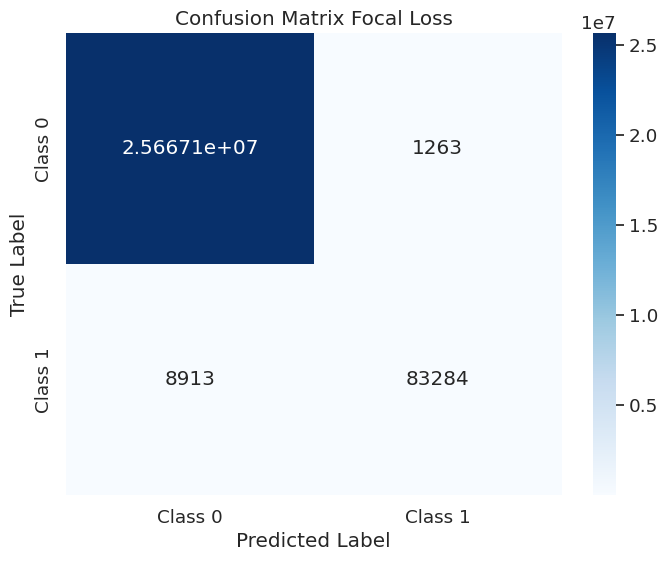

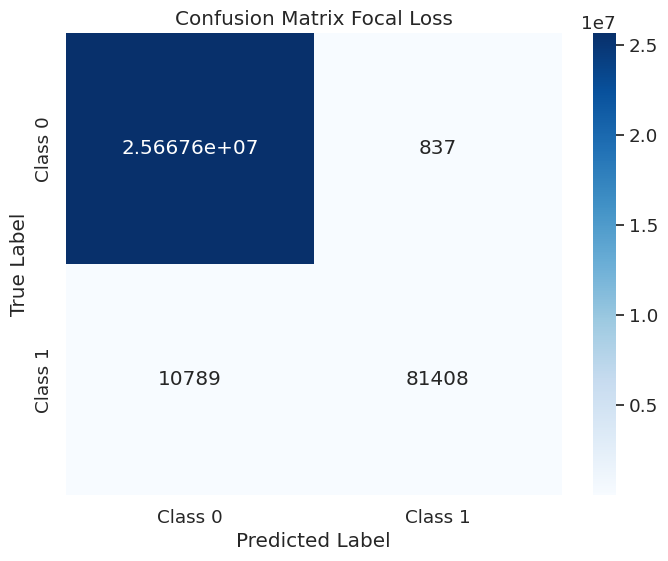

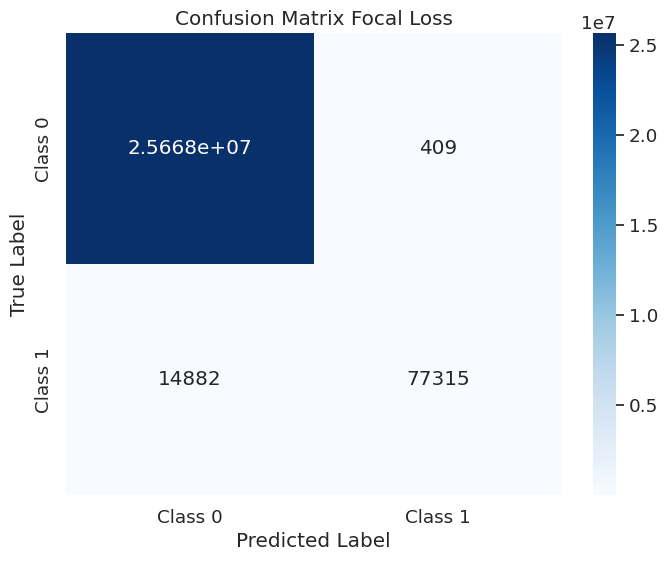

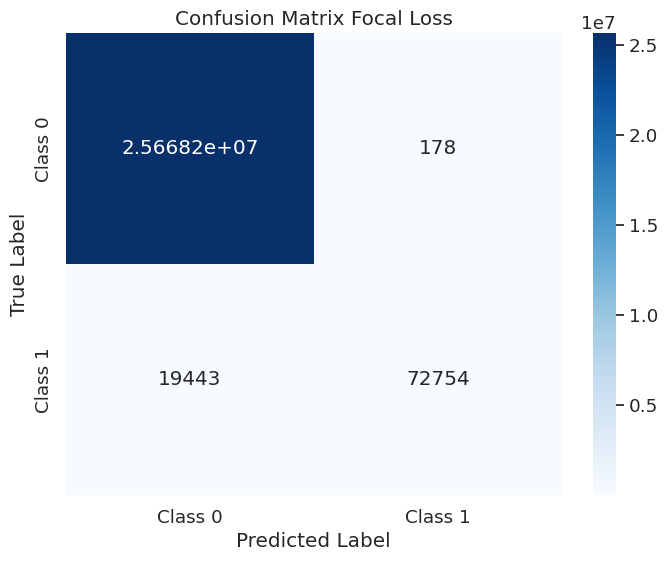

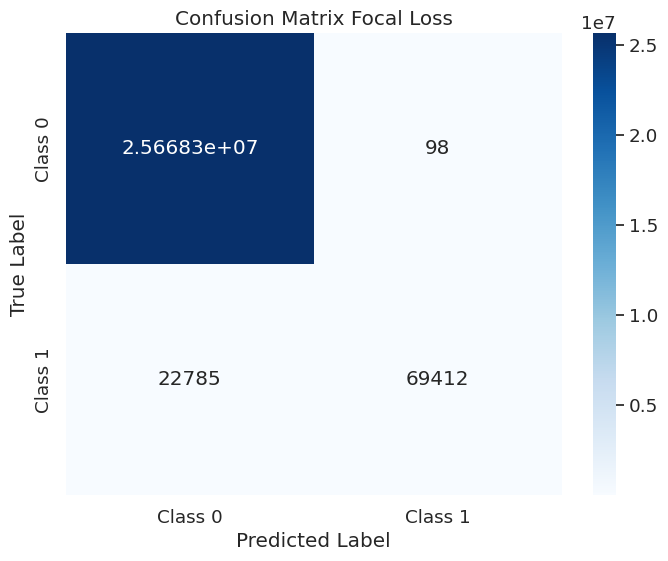

In [17]:
print('--Focal Loss--')
plot_confusion_matrix(pred_masks, selected_mask, thresholds, 'Focal')